In [0]:
#Data Preprocessing

In [0]:
!pip install helpers

In [0]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import struct
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime
import IPython.display as ipd
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#my_folder = "/content/drive/My Drive/Data/Respiratory_Sound/audio"
! ls "/content/drive/My Drive/Data/Respiratory_Sound/audio/fold1"


101_1b1_Al_sc_Meditron.wav  109_1b1_Pl_sc_Litt3200.wav
101_1b1_Pr_sc_Meditron.wav  109_1b1_Pr_sc_Litt3200.wav
102_1b1_Ar_sc_Meditron.wav  110_1b1_Pr_sc_Meditron.wav
103_2b2_Ar_mc_LittC2SE.wav  110_1p1_Al_sc_Meditron.wav
104_1b1_Al_sc_Litt3200.wav  110_1p1_Ll_sc_Meditron.wav
104_1b1_Ar_sc_Litt3200.wav  110_1p1_Lr_sc_Meditron.wav
104_1b1_Ll_sc_Litt3200.wav  110_1p1_Pr_sc_Meditron.wav
104_1b1_Lr_sc_Litt3200.wav  111_1b2_Tc_sc_Meditron.wav
104_1b1_Pl_sc_Litt3200.wav  111_1b3_Tc_sc_Meditron.wav
104_1b1_Pr_sc_Litt3200.wav  112_1b1_Ar_sc_Meditron.wav
105_1b1_Tc_sc_Meditron.wav  112_1b1_Lr_sc_Meditron.wav
106_2b1_Pl_mc_LittC2SE.wav  112_1p1_Ll_sc_Litt3200.wav
106_2b1_Pr_mc_LittC2SE.wav  112_1p1_Pl_sc_Litt3200.wav
107_2b3_Al_mc_AKGC417L.wav  112_1p1_Pr_sc_Litt3200.wav
107_2b3_Ar_mc_AKGC417L.wav  113_1b1_Al_sc_Litt3200.wav
107_2b3_Ll_mc_AKGC417L.wav  113_1b1_Ar_sc_Litt3200.wav
107_2b3_Lr_mc_AKGC417L.wav  113_1b1_Ll_sc_Litt3200.wav
107_2b3_Pl_mc_AKGC417L.wav  113_1b1_Lr_sc_Litt3200.wav
107_2b3_Pr

In [77]:

ipd.Audio("/content/drive/My Drive/Data/Respiratory_Sound/audio/fold1/101_1b1_Al_sc_Meditron.wav")

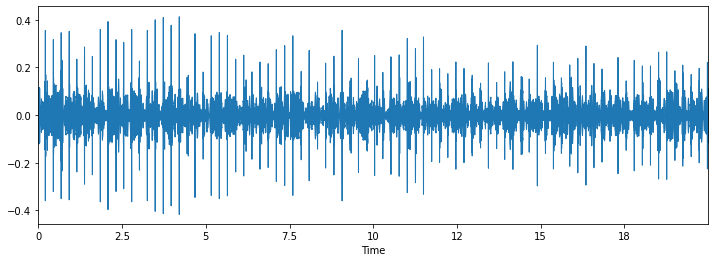

In [78]:
filename = "/content/drive/My Drive/Data/Respiratory_Sound/audio/fold1/101_1b1_Al_sc_Meditron.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [6]:
metadata = pd.read_csv("/content/drive/My Drive/Data/Respiratory_Sound/patient_diagnosis.csv")
metadata.head()

slice_file_name  patient record_index  ...   fold classID class
0  104_1b1_Ar_sc_Litt3200.wav      104          1b1  ...  fold1       3  COPD
1  104_1b1_Ll_sc_Litt3200.wav      104          1b1  ...  fold1       3  COPD
2  104_1b1_Lr_sc_Litt3200.wav      104          1b1  ...  fold1       3  COPD
3  104_1b1_Pl_sc_Litt3200.wav      104          1b1  ...  fold1       3  COPD
4  104_1b1_Pr_sc_Litt3200.wav      104          1b1  ...  fold1       3  COPD

[5 rows x 9 columns]

In [0]:
max_pad_len = 4000

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        #print(audio)
        #print(sample_rate) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        #print(mfccs)
        #print(mfccs.shape[1])
        pad_width = max_pad_len - mfccs.shape[1]
        #print(pad_width)
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [8]:
features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath("/content/drive/My Drive/Data/Respiratory_Sound/audio/"),str(row["fold"])+'/',str(row["slice_file_name"]))
    
    #class_label = row["class_name"]
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  920  files


In [0]:
#Convert Data

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [0]:
#Build Model

num_rows = 40
#num_columns = 174
num_columns = 4000
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [82]:
x_test[1].shape

(184, 40, 4000, 1)

In [11]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 3999, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 1999, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 1999, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 1998, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 999, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 999, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 998, 64)        8

In [12]:
#Training

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
3/3 [==============================] - ETA: 0s - loss: 1.5367 - accuracy: 0.5924
Epoch 00001: val_loss improved from inf to 0.99056, saving model to saved_models/weights.best.basic_cnn.hdf5
3/3 [==============================] - 26s 9s/step - loss: 1.5367 - accuracy: 0.5924 - val_loss: 0.9906 - val_accuracy: 0.8261
Epoch 2/72
3/3 [==============================] - ETA: 0s - loss: 1.1341 - accuracy: 0.8736
Epoch 00002: val_loss did not improve from 0.99056
3/3 [==============================] - 26s 9s/step - loss: 1.1341 - accuracy: 0.8736 - val_loss: 1.1133 - val_accuracy: 0.8261
Epoch 3/72
3/3 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.8736
Epoch 00003: val_loss did not improve from 0.99056
3/3 [==============================] - 26s 9s/step - loss: 1.0961 - accuracy: 0.8736 - val_loss: 1.1018 - val_accuracy: 0.8261
Epoch 4/72
3/3 [==============================] - ETA: 0s - loss: 1.0655 - accuracy: 0.8736
Epoch 00004: val_loss did not improve fr

In [13]:
#Testing

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8913043737411499
Testing Accuracy:  0.820652186870575


In [0]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [99]:
import time
# run prediction
start = time.time()
print_prediction("/content/drive/My Drive/Data/Respiratory_Sound/audio/fold1/104_1b1_Ar_sc_Litt3200.wav")
print("RUNTIME: {}".format(time.time() - start))

The predicted class is: COPD 

Asthma 		 :  0.00000056099423773048329167068005
Bronchiectasis 		 :  0.00011315031588310375809669494629
Bronchiolitis 		 :  0.00034201232483610510826110839844
COPD 		 :  0.99906820058822631835937500000000
Healthy 		 :  0.00000005804198011105654586572200
LRTI 		 :  0.00000017522179973639140371233225
Pneumonia 		 :  0.00047538784565404057502746582031
URTI 		 :  0.00000046113311213957786094397306
RUNTIME: 1.2544214725494385
